# Modelado del conjunto de datos
A lo largo de este notebook se cubre la tercera fase de la metodología CRIPS-DM, en este caso la preparación dec los datos

1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo del proyecto.

2. **Comprensión de los Datos (Data Understanding)**
   - Relacionada con la carga y primera evaluación del conjunto de datos. Se divide a su vez en :


3. **Preparación de los Datos (Data Preparation)** 
   - Consistente en la limpieza, preparación y extracción de características de los datos.

4. <span style="color:#66FF99;">**Modelado (Modeling)**  </span> 
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico. En este caso, el modelo a emplear se tratará de un ensemble que combina RetinaNet con Segment Anything Model.

5. **Evaluación (Evaluation)**  
   - Evaluación de los resultados obtenidos por el modelo.

6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso.


### Arquitectura propuesta


En este caso, la arquitectura propuesta, representada inferiormente, puede dividirse en dos bloques diferenciados:

1) Detector de objetos mediante RetinaNet, obtieninedo como salida las bounding-boxes asociadas.
2) Segmentador de instancias mediante Segment Anything Model a partir de las bounding boxes anteriores.
3) Agrupador de máscaras de instancias en formato de imagen con las máscaras de la segmentación semántica correspondiente.


<img src="./../assets/figs/proposed_retinnet.png" alt="Arquitectura propuesta empleando RetinaNet" style="width: 70%; height: auto;">

### Detector de objetos

In [ ]:
import importlib
import utils 

importlib.reload(utils)

from tqdm import tqdm
import torchvision
from torchvision.models.detection import retinanet_resnet50_fpn
import torchvision.transforms as T
import torch.nn.functional as F

from PIL import Image
import torch
import tensorflow as tf
import numpy as np
import os
from pycocotools.coco import COCO
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from utils import  load_yaml_file

import torchvision
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
import matplotlib.patches as patches
import matplotlib.patches as mpatches

import random


from utils import plot_image_and_mask, mask_generator, mask_generator_one_hot, plot_one_hot_encoded_masks, plot_bounding_boxes, plot_differences_batch



Carga del modelo y sus pesos asociados, en este caso del conjunto de modelos entrenados de torchvision

In [343]:
model = retinanet_resnet50_fpn(pretrained=True)

c:\Users\ruben\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Se imprime su estructura en detalle y se pone el modelo en modo `eval`, bloqueando así el entrenamiento

In [344]:
model.eval()  

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


Se carga un subconjunto de imágenes del conjunto de datos, para evaluar los resultados obtenidos

In [345]:
yaml = load_yaml_file()

objetives = yaml["objetive_classes"]
objetives


['person',
 'car',
 'motorcycle',
 'bus',
 'traffic light',
 'backpack',
 'handbag',
 'cell phone',
 'chair',
 'dining table']

In [346]:

N_CLASSES = len(objetives) + 1

DIR_TRAIN_ANNOTATIONS = yaml["dirs"]["anotaciones"]["train"]
DIR_TRAIN_IMGS = yaml["dirs"]["imagenes"]["train"]
DIR_TRAIN_IMGS = os.path.abspath(os.path.join(os.getcwd(), "..", DIR_TRAIN_IMGS))

coco=COCO(os.path.join(os.getcwd(),"..", DIR_TRAIN_ANNOTATIONS))

loading annotations into memory...
Done (t=95.79s)
creating index...
index created!


In [347]:
categories = coco.loadCats(coco.getCatIds())
category_info_id = {cat['id']: cat['name'] for cat in categories}
category_info_name = { cat['name']:cat['id'] for cat in categories}

id_objetives = [category_info_name[name] for name in objetives]
category_info_objetive = {i:category_info_id[i] for i in id_objetives}


Asimismo, se define un threshold que omitirá máscaras con confianza poco significativas

In [348]:
CONS_TRHESHOLD = 0.5
CONS_THRESHOLD_SEGMENTATION = 0.5

In [349]:

img_ids = set(coco.getImgIds(catIds=id_objetives[0]))

for cat in id_objetives[1:]:
    img_ids |= set(coco.getImgIds(catIds=cat))

img_ids = list(img_ids)


print(f"Las imagenes con alguna instancia de las clases target son {len(img_ids)}")

Las imagenes con alguna instancia de las clases target son 79542


In [350]:
img, mascara =  mask_generator(coco,img_ids[0], id_objetives  ,DIR_TRAIN_IMGS,  threshold = 200)


In [351]:
category_info_objetive_plot = category_info_objetive.copy()
category_info_objetive_plot[0] = "blackground"

Se comprueba de forma gráfica que la carga de los datos ha sido correcta

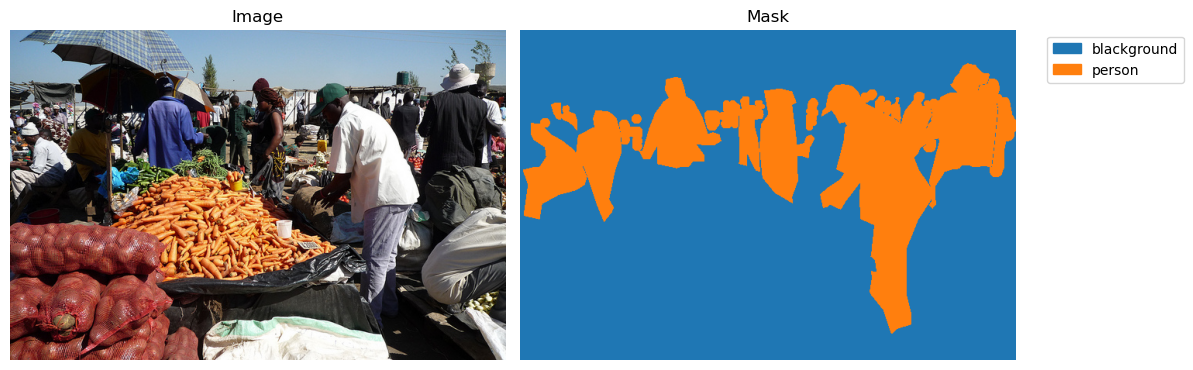

In [352]:
plot_image_and_mask(img, mascara, category_info_objetive_plot)

Para el uso del modelo, se convierte el `np.array` en `torch.Tensor` para poder ingestar en el modelo, dado que esta implementado en torch en lugar de Tensorflow.

In [353]:
img_ids = coco.getImgIds()
img_info = coco.loadImgs(img_ids[0])[0]
img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"

image = Image.open(img_path).convert("RGB")

transform = T.Compose([
    T.ToTensor()
])
img_tensor = transform(image).unsqueeze(0)

Llamamos a la ejecucuón para esta primera instancia y comprobar el funcionamiento de la detección

In [354]:
with torch.no_grad():
    outputs = model(img_tensor)

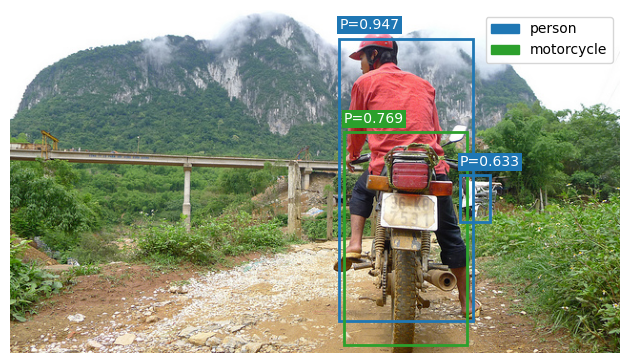

In [355]:
plot_bounding_boxes(image=image,result= outputs[0],category_info_objetive=category_info_objetive_plot, threshold=0.5)

Una vez testeada, se automatiza la detección de objetos en un subconjunto de las imágenes, que supondrán la salida del primer bloque del modelo.

In [356]:

id_images = []
images = []
results_detection = []

for img_id in tqdm(img_ids[:100], desc="Generando las bounding boxes"):

    img_info = coco.loadImgs(img_id)[0]
    img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"
    image = Image.open(img_path).convert("RGB")

    transform = T.Compose([
        T.ToTensor()
    ])
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img_tensor)
        
    results_detection.append(outputs)
    id_images.append(img_id)
    images.append(image)

Generando las bounding boxes: 100%|██████████| 100/100 [12:32<00:00,  7.52s/it]


C:\Users\ruben\AppData\Local\Temp\ipykernel_60472\2949144618.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = {cls: plt.cm.get_cmap('tab10')(i) for i, cls in enumerate(id_objetives)}


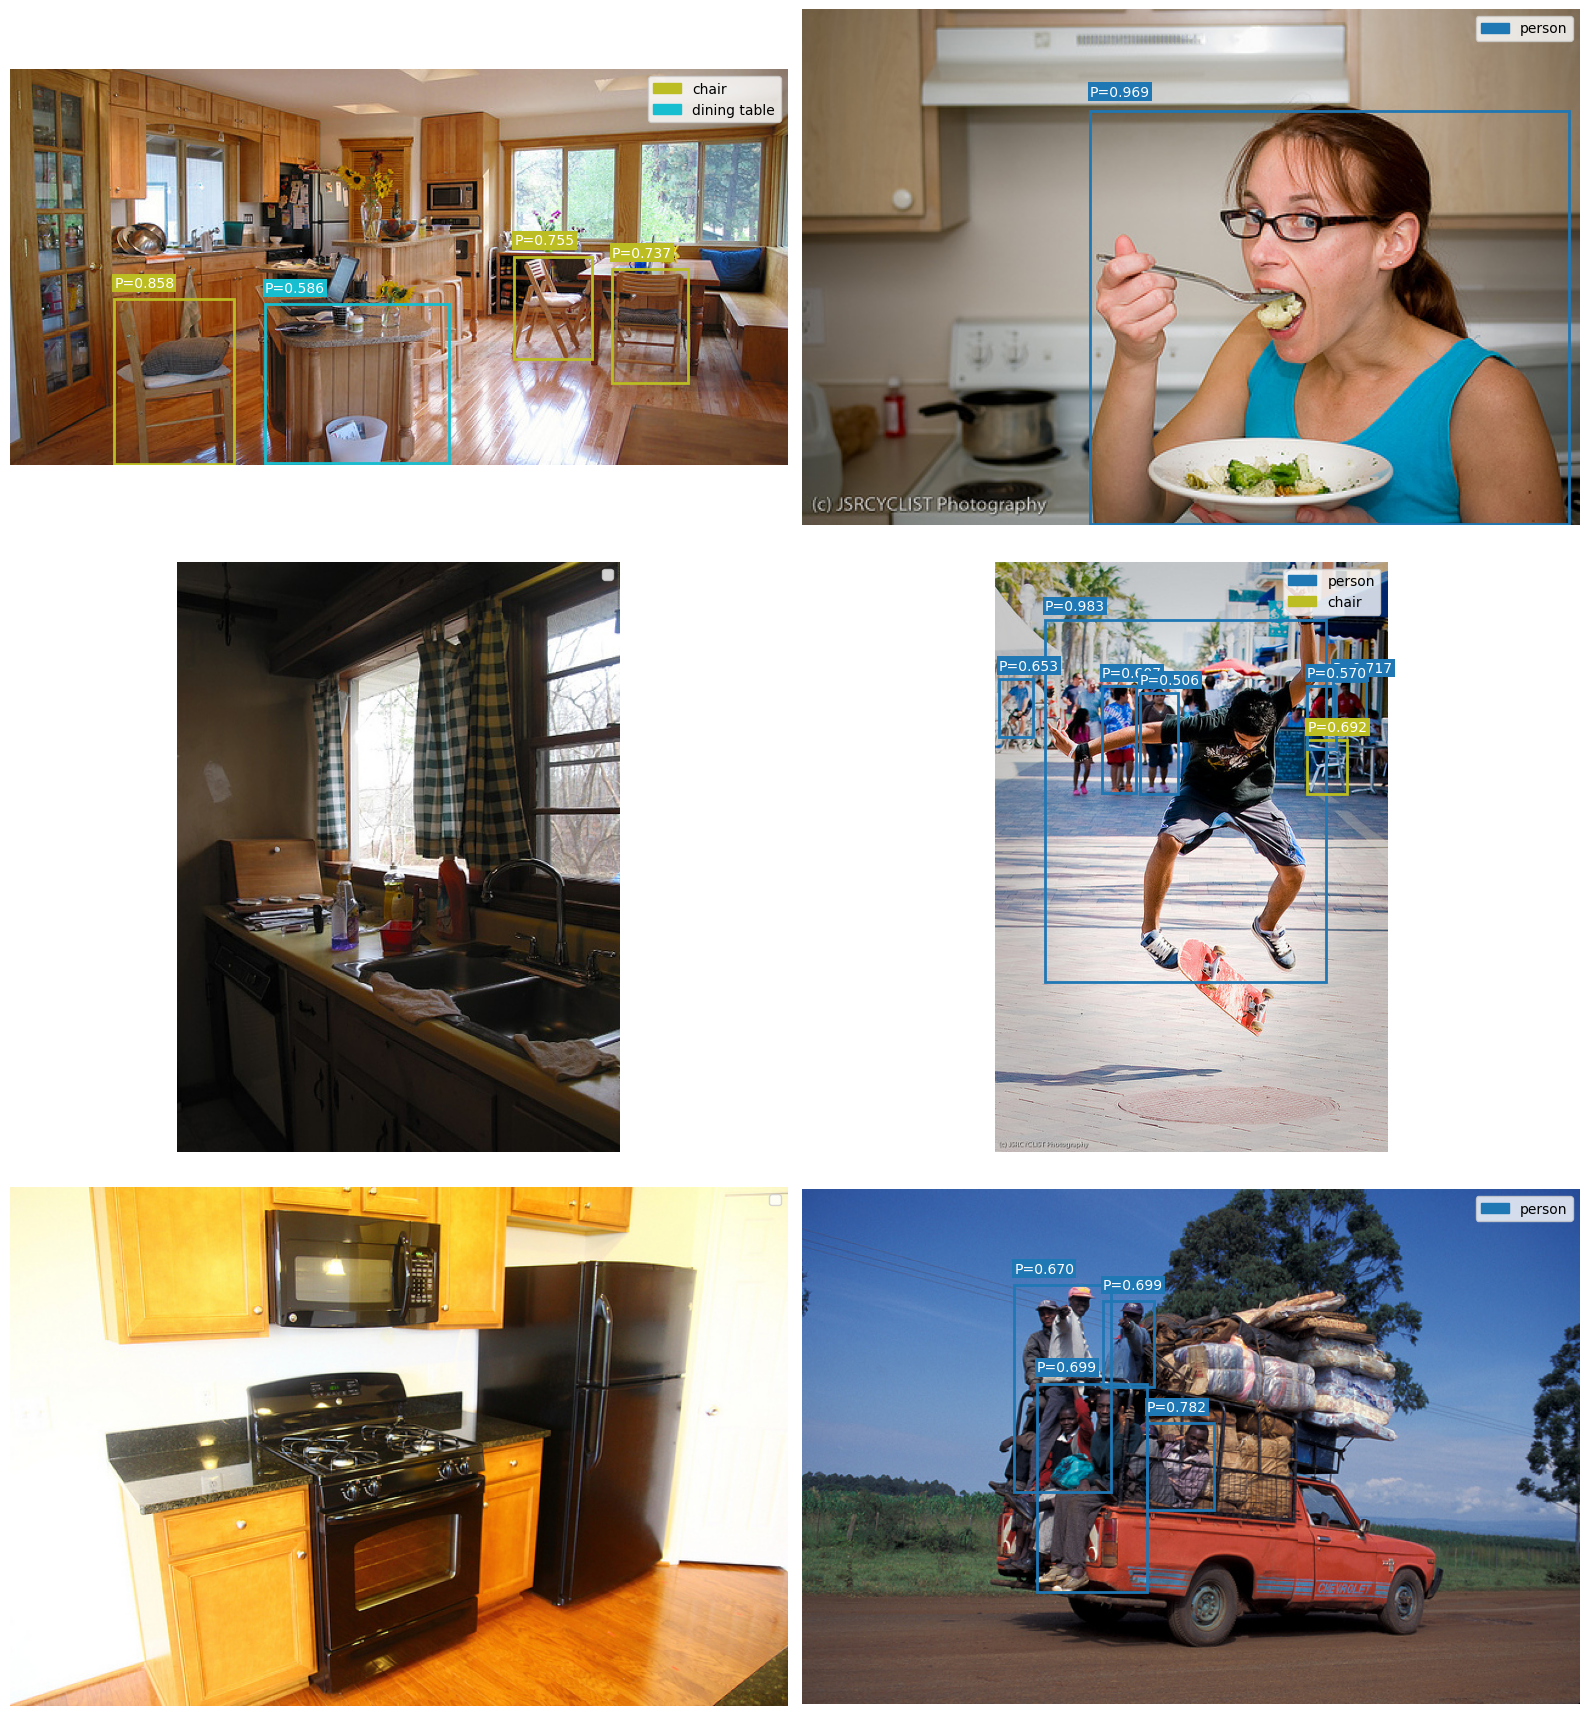

In [357]:
def plot_bounding_boxes(images, results, category_info_objetive, threshold=0.5):

    n = len(images)
    cols = 2
    rows = (n + 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 6 * rows))
    axes = axes.flatten() if n > 1 else [axes]

    id_objetives = category_info_objetive.keys()
    color_map = {cls: plt.cm.get_cmap('tab10')(i) for i, cls in enumerate(id_objetives)}

    for idx, (image, result) in enumerate(zip(images, results)):
        ax = axes[idx]
        ax.imshow(image)
        classess_found = []

        for box, score, label in zip(result['boxes'], result['scores'], result['labels']):
            if label.item() in id_objetives and score > threshold:
                x_min, y_min, x_max, y_max = box
                width, height = x_max - x_min, y_max - y_min
                color = color_map[label.item()]
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2,
                                         edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min - 10, f"P={score.item():.3f}", color='white', fontsize=10,
                        bbox=dict(facecolor=color, edgecolor='none', pad=1.5))
                classess_found.append(label)

        handles = [mpatches.Patch(color=color_map[cls], label=category_info_objetive[cls])
                   for cls in id_objetives if cls in classess_found]
        ax.legend(handles=handles, loc='upper right')
        ax.axis('off')

    # Hide any unused subplots
    for i in range(len(images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



results_processed  = [result_detection[0] for result_detection in results_detection]
plot_bounding_boxes(images[15:21], results_processed[15:21], category_info_objetive_plot )

### Generador de máscaras mediante Fast-SAM

A continuación se desarrolla el segundo bloque que conforma el modelo, en este caso el bloque encargado de generar las máscaras de segmentación a partir de los bounding boxes obtenidos en el bloque anterior.

In [358]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

En este caso nos decantamos por el modelo de mayor número de parámetros (modelo huge, de 4.89 billones de parámetros) para la obtención de los resultados de la mejor calidad posible.

In [359]:

sam_checkpoint = r"C:\Users\ruben\Desktop\code_tfm\models\SAM\sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device= "cpu" )

sam_model = SamPredictor(sam)


In [360]:
final_masks = []
masks_scores = []
masks_logits = []
ids_image = []

segmentation_results = []
for i, (img_id, results_detection) in enumerate(tqdm(zip(id_images[:5], results_processed[:5]), total=len(id_images[:5]))):

    masks_image = []
    scores_image = []
    logits_image = []

    img_info = coco.loadImgs(img_id)[0]
    img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sam_model.set_image(image)

    for box, score, label in zip(results_detection['boxes'], results_detection['scores'], results_detection['labels']):
        if(score > CONS_TRHESHOLD and label.item() in category_info_objetive.keys()):
            masks, scores, logits = sam_model.predict(
                point_coords=None,
                point_labels=None,
                box= np.array(box.tolist())[None, :] ,
                multimask_output=False
            )


            
            masks_image.append(masks)
            scores_image.append(scores)
            logits_image.append(logits)

    final_masks.append(masks_image)
    masks_scores.append(scores_image)
    masks_logits.append(logits_image)
    ids_image.append(img_id)




100%|██████████| 5/5 [10:23<00:00, 124.62s/it]


In [361]:

final_masks = []
masks_scores = []
masks_logits = []
ids_image = []

for i, (img_id, results_detection) in enumerate(tqdm(zip(id_images[:5], results_processed[:5]), total=len(id_images[:5]))):

    masks_image = []
    scores_image = []
    logits_image = []
    labels_image = []

    img_info = coco.loadImgs(img_id)[0]
    img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sam_model.set_image(image)

    final_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    current_scores = np.zeros(image.shape[:2], dtype=np.uint8)

    for box, score, label in zip(results_detection['boxes'], results_detection['scores'], results_detection['labels']):
        if(score > CONS_TRHESHOLD and label.item() in category_info_objetive.keys()):
            masks, scores, logits = sam_model.predict(
                point_coords=None,
                point_labels=None,
                box= np.array(box.tolist())[None, :] ,
                multimask_output=False
            )
            
            
            # print("image has shape ",image.shape )
            # print("mask have shape ",masks.shape )
            # print("logits has shape ",logits.shape )
            
            # print("\n")
            
            masks_image.append(masks)
            scores_image.append(scores)
            logits_image.append(logits[0])
            labels_image.append(label.item())

    # print("scores are ", scores_image, "for classes ", labels_image)


    for mask, mask_score, label in zip(masks_image, scores_image, labels_image):
        if np.any(mask):
            # print("mask has avlue and label is ", label)
            mask_values = np.where(mask, mask_score, 0)
            final_mask = np.where(mask_values > current_scores , label, final_mask)
            # print("current final value is ", np.unique(final_mask))
            current_scores = np.maximum(mask_values, current_scores)

    # print("\n\n")




    final_masks.append(final_mask)
    masks_scores.append(current_scores)
    #masks_logits.append(stacked_logits)
    ids_image.append(img_id)




 20%|██        | 1/5 [02:05<08:20, 125.11s/it]

scores are  [array([0.94392043], dtype=float32), array([0.6683726], dtype=float32), array([0.93552524], dtype=float32)] for classes  [1, 4, 1]
mask has avlue and label is  1
current final value is  [0 1]
mask has avlue and label is  4
current final value is  [0 1 4]
mask has avlue and label is  1
current final value is  [0 1 4]





 40%|████      | 2/5 [04:04<06:04, 121.59s/it]

scores are  [array([0.9974719], dtype=float32)] for classes  [1]
mask has avlue and label is  1
current final value is  [0 1]





 60%|██████    | 3/5 [05:59<03:56, 118.49s/it]

scores are  [array([0.9182514], dtype=float32), array([0.8783295], dtype=float32), array([0.92031217], dtype=float32), array([0.9077764], dtype=float32), array([0.93095696], dtype=float32), array([0.91917837], dtype=float32), array([0.9221735], dtype=float32), array([0.7297172], dtype=float32), array([0.8954935], dtype=float32), array([0.50874877], dtype=float32)] for classes  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mask has avlue and label is  1
current final value is  [0 1]
mask has avlue and label is  1
current final value is  [0 1]
mask has avlue and label is  1
current final value is  [0 1]
mask has avlue and label is  1
current final value is  [0 1]
mask has avlue and label is  1
current final value is  [0 1]
mask has avlue and label is  1
current final value is  [0 1]
mask has avlue and label is  1
current final value is  [0 1]
mask has avlue and label is  1
current final value is  [0 1]
mask has avlue and label is  1
current final value is  [0 1]
mask has avlue and label is  1
current f

 80%|████████  | 4/5 [07:59<01:59, 119.26s/it]

scores are  [array([0.99504495], dtype=float32)] for classes  [1]
mask has avlue and label is  1
current final value is  [0 1]





100%|██████████| 5/5 [10:02<00:00, 120.44s/it]

scores are  [array([0.9894841], dtype=float32), array([0.8769097], dtype=float32)] for classes  [1, 1]
mask has avlue and label is  1
current final value is  [0 1]
mask has avlue and label is  1
current final value is  [0 1]





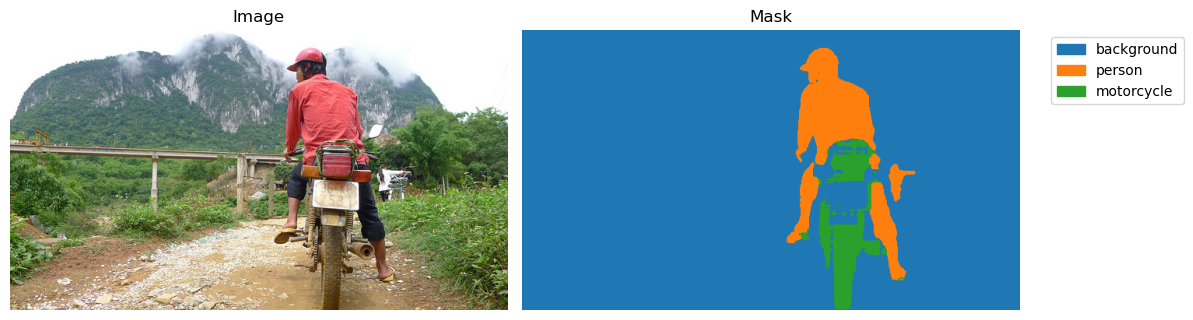

In [362]:

img_info = coco.loadImgs(ids_image[0])[0]
img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
category_info_objetive[0] = "background"
plot_image_and_mask(image, final_masks[0][0],  category_info_objetive )


### Obtención de las métricas de rendimiento

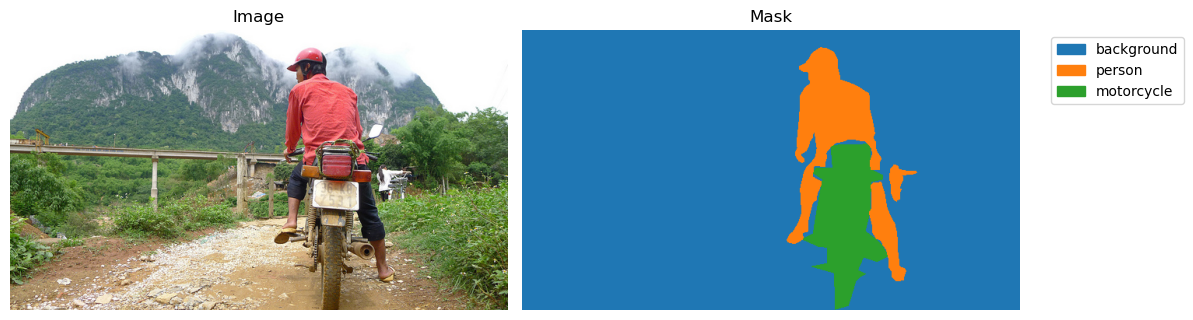

In [363]:
img_info = coco.loadImgs(ids_image[0])[0]
height, width = img_info['height'], img_info['width']

# Get all annotations for the image
ann_ids = coco.getAnnIds(imgIds=ids_image[0])
anns = coco.loadAnns(ann_ids)

# Initialize mask
mask = np.zeros((height, width), dtype=np.uint8)

# Fill in the mask with class IDs
for ann in anns:
    category_id = ann['category_id']

    if(category_id in category_info_objetive.keys()):
    
        binary_mask = coco.annToMask(ann)
        mask[binary_mask == 1] = category_id

plot_image_and_mask(image, mask,  category_info_objetive )


C:\Users\ruben\AppData\Local\Temp\ipykernel_60472\4121677733.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_id_to_name))  # or any other colormap


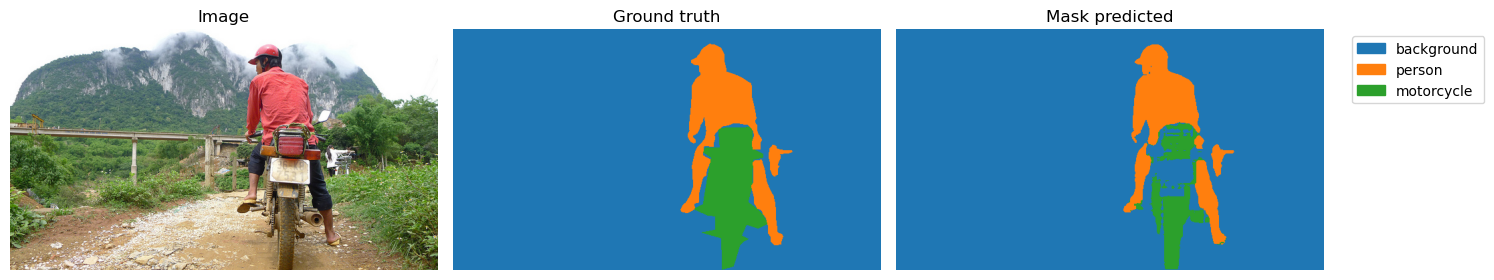

In [364]:
def plot_differences(image, mask_gt, mask_predicted,class_id_to_name):
    class_ids = sorted([cid for cid in np.unique(mask_gt)])
    colors = plt.cm.get_cmap('tab10', len(class_id_to_name))  # or any other colormap

    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    ax[0].imshow(image)
    ax[0].set_title("Image")
    ax[0].axis("off")

    # Use ListedColormap to map class IDs to colors
    mask_colored = np.zeros((mask_gt.shape[0], mask_gt.shape[1], 3), dtype=np.uint8)
    for i, cid in enumerate(class_ids):
        mask_colored[mask_gt == cid] = (np.array(colors(i)[:3]) * 255).astype(np.uint8)

    ax[1].imshow(mask_colored)
    ax[1].set_title("Ground truth")
    ax[1].axis("off")

    mask_colored = np.zeros((mask_predicted.shape[0], mask_predicted.shape[1], 3), dtype=np.uint8)
    for i, cid in enumerate(class_ids):
        mask_colored[mask_predicted == cid] = (np.array(colors(i)[:3]) * 255).astype(np.uint8)

    ax[2].imshow(mask_colored)
    ax[2].set_title("Mask predicted")
    ax[2].axis("off")

    handles = [mpatches.Patch(color=colors(i), label=class_id_to_name[cid])
               for i, cid in enumerate(class_ids)]
    ax[2].legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

plot_differences(image, mask, final_masks[0][0],category_info_objetive)

In [377]:
ids_image

[391895, 522418, 184613, 318219, 554625, 554625]

C:\Users\ruben\AppData\Local\Temp\ipykernel_60472\3713276220.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_id_to_name))  # or another colormap


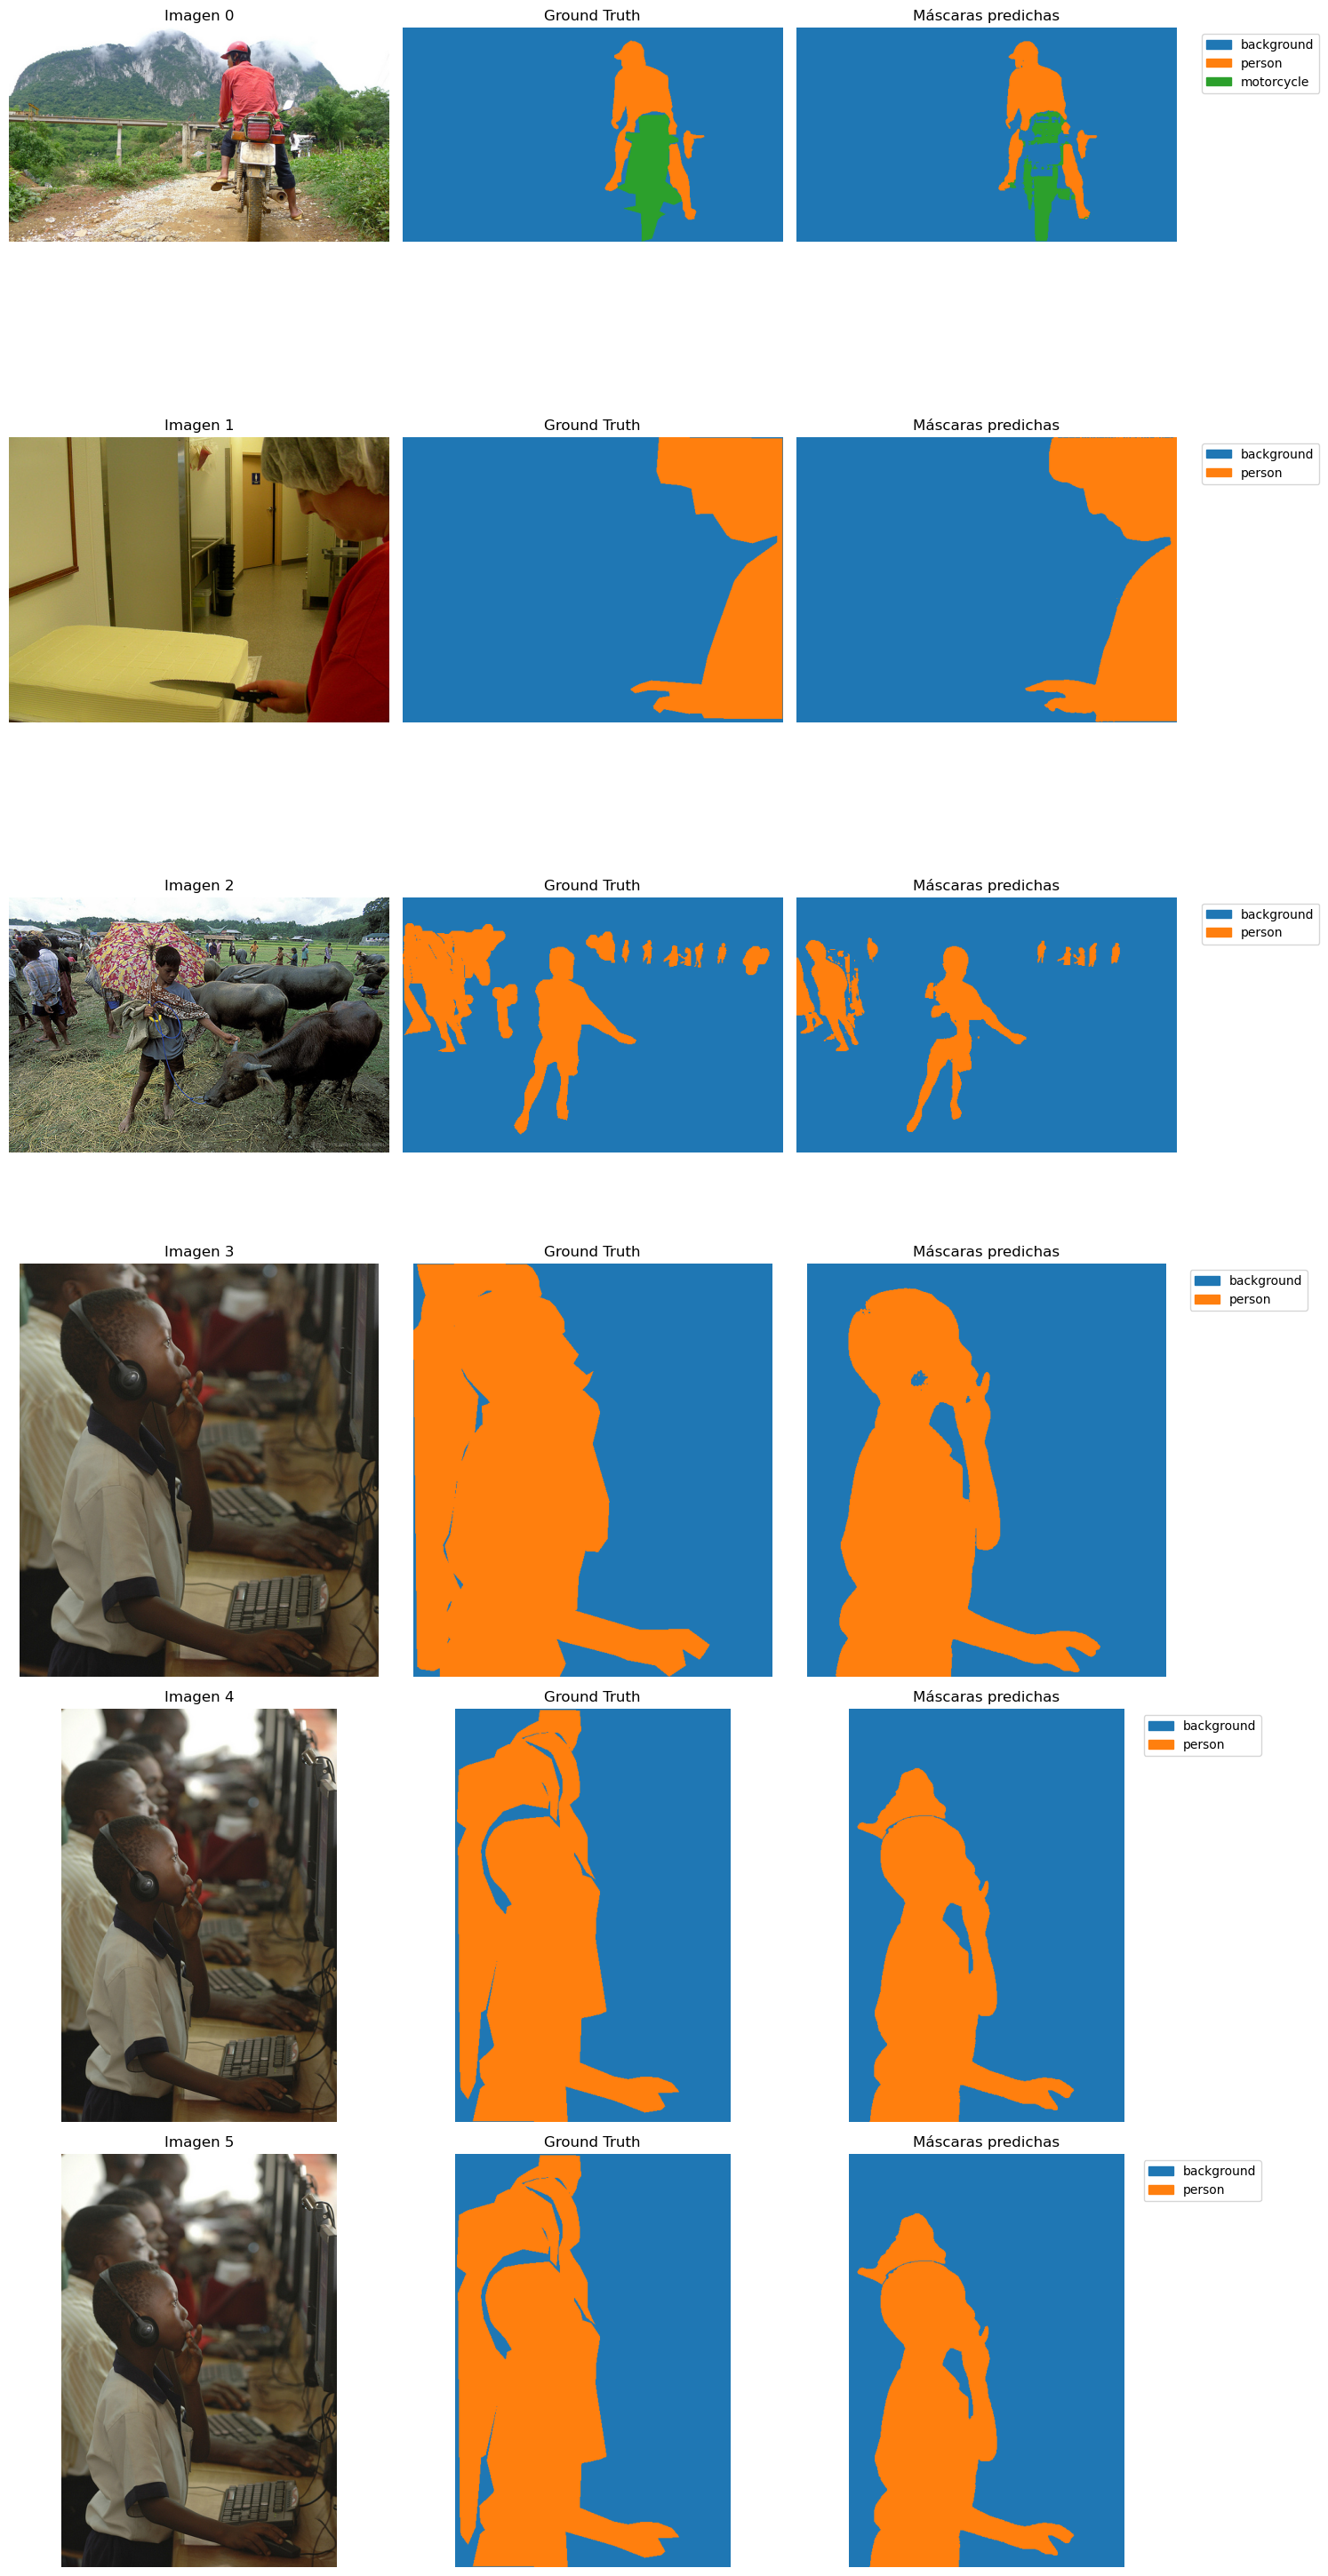

In [ ]:


plot_image = []
plot_mask_gt = []
plot_mask_result = []

for i, img_id in enumerate(ids_image):
    img_info = coco.loadImgs(img_id)[0]
    height, width = img_info['height'], img_info['width']

    img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get all annotations for the image
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    # Initialize mask
    mask = np.zeros((height, width), dtype=np.uint8)

    # Fill in the mask with class IDs
    for ann in anns:
        category_id = ann['category_id']

        if(category_id in category_info_objetive.keys()):
        
            binary_mask = coco.annToMask(ann)
            if binary_mask.shape != mask.shape:
                binary_mask = cv2.resize(binary_mask, (width, height), interpolation=cv2.INTER_NEAREST)
            mask[binary_mask == 1] = category_id

    plot_image.append(image)
    plot_mask_gt.append(mask)
    plot_mask_result.append(final_masks[i][0])
    

plot_differences_batch(plot_image, plot_mask_gt, plot_mask_result, category_info_objetive)
    

Métricas

In [366]:
def compute_iou(pred_probs, target, threshold=0.5):
    """
    Compute per-class and mean IoU for semantic segmentation.

    Args:
        pred_probs (np.ndarray): Array of shape (C, H, W) with predicted probabilities per class.
        target (np.ndarray): Ground truth array of shape (H, W) with class indices.
        threshold (float): Threshold to binarize prediction, not needed if using argmax.

    Returns:
        per_class_iou (np.ndarray): IoU for each class.
        mean_iou (float): Mean IoU across classes.
    """
    num_classes = pred_probs.shape[0]
    pred = np.argmax(pred_probs, axis=0)  # Shape (H, W)

    per_class_iou = []
    for cls in range(num_classes):
        pred_mask = (pred == cls)
        target_mask = (target == cls)

        intersection = np.logical_and(pred_mask, target_mask).sum()
        union = np.logical_or(pred_mask, target_mask).sum()

        if union == 0:
            iou = float('nan')  # Or 0, or continue
        else:
            iou = intersection / union

        per_class_iou.append(iou)

    per_class_iou = np.array(per_class_iou)
    mean_iou = np.nanmean(per_class_iou)

    return per_class_iou, mean_iou

In [367]:
import numpy as np
from sklearn.metrics import average_precision_score

def compute_mean_average_precision(pred_probs, target):
    """
    Compute per-class and mean Average Precision (mAP) for semantic segmentation.

    Args:
        pred_probs (np.ndarray): Array of shape (C, H, W) with predicted probabilities per class.
        target (np.ndarray): Ground truth array of shape (H, W) with class indices.

    Returns:
        per_class_ap (np.ndarray): AP for each class.
        mean_ap (float): Mean AP across classes.
    """
    num_classes, H, W = pred_probs.shape
    target_flat = target.flatten()  # Shape: (H*W,)
    
    per_class_ap = []

    for cls in range(num_classes):
        # Ground truth binary mask for class
        gt_binary = (target_flat == cls).astype(np.uint8)  # shape: (H*W,)
        # Predicted probabilities for class
        pred_scores = pred_probs[cls].flatten()  # shape: (H*W,)

        if np.sum(gt_binary) == 0:
            ap = float('nan')  # Class not present in ground truth
        else:
            ap = average_precision_score(gt_binary, pred_scores)

        per_class_ap.append(ap)

    per_class_ap = np.array(per_class_ap)
    mean_ap = np.nanmean(per_class_ap)

    return per_class_ap, mean_ap


In [368]:
import numpy as np
from sklearn.metrics import average_precision_score
from collections import defaultdict

def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0.0

def compute_instance_map(predictions, ground_truths, iou_threshold=0.5, num_classes=None):
    """
    Compute per-class AP and mAP for instance segmentation.
    """
    if num_classes is None:
        class_ids = set([gt['class_id'] for gt in ground_truths] + [p['class_id'] for p in predictions])
    else:
        class_ids = range(num_classes)
    
    ap_per_class = []

    for cls in class_ids:
        preds_cls = [p for p in predictions if p['class_id'] == cls]
        gts_cls = [g for g in ground_truths if g['class_id'] == cls]

        gt_matched = np.zeros(len(gts_cls), dtype=bool)
        scores = []
        labels = []

        preds_cls.sort(key=lambda x: x['score'], reverse=True)

        for pred in preds_cls:
            best_iou = 0
            best_idx = -1
            for i, gt in enumerate(gts_cls):
                if not gt_matched[i]:
                    iou = compute_iou(pred['mask'], gt['mask'])
                    if iou > best_iou:
                        best_iou = iou
                        best_idx = i
            if best_iou >= iou_threshold:
                gt_matched[best_idx] = True
                labels.append(1)  # True Positive
            else:
                labels.append(0)  # False Positive
            scores.append(pred['score'])

        # False negatives: unmatched ground truths
        if len(gts_cls) > 0:
            ap = average_precision_score(labels + [1]*np.sum(~gt_matched), scores + [0.0]*np.sum(~gt_matched))
        else:
            ap = float('nan')  # No ground truth for this class

        ap_per_class.append(ap)

    ap_per_class = np.array(ap_per_class)
    mean_ap = np.nanmean(ap_per_class)

    return ap_per_class, mean_ap


In [369]:
start = time.time()

end = time.time()

print('Tiempo de procesado ' + str((end - start)) + ' s')

Tiempo de procesado 0.003776073455810547 s
